# Project: Job Change
**Author: Bill Bao**

## 1. Importing Library

We need libraries for data cleaning, preparing, analyzing, ensembling, training machine learning models, visualizing and evaluating.

In [1]:
# data analysis and preparing
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

# feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.ensemble import ExtraTreesClassifier

# machine learning models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import CategoricalNB, MultinomialNB

# other
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, mean_squared_error,confusion_matrix, plot_roc_curve, roc_auc_score, make_scorer, recall_score
from sklearn import metrics, tree

# Ensemble
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier, GradientBoostingClassifier

## 2. Acquire Data

In [2]:
data = pd.read_csv("data-science-job-change.csv")
data.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


## 3. Prepare and clean data

First, let's what our data looks like, so that I could have idea to clean it.

In [3]:
print(data.shape)

(19158, 14)


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

As we can see above, most of features are categorical.
The feature types are identified as follows:

* Categorical - gender, relevant_experience, enrolled_university, education_level, major_discipline, experience, company_size, company_type, last_new_job.
* Continuous - city_development_index, training_hours. 
* Discrete - enrollee_id, city.

**Target: categorical (0 or 1)**

In addition, enrollee_id is not useful for prediction, and city is categorised as categorical.

In [5]:
to_drop = ['enrollee_id']
data.drop(to_drop, inplace=True, axis=1)

Besides, it is important to distinguish nominal, ordinal and binary.

* Nominal - city, enrolled_university, major_discipline, company_type.
* Ordinal - *relevent_experience*, education_level, experience, company_size, last_new_job.
* Binary - gender

According to the observation, the italic features might be transformed into binary features.

In [6]:
binary_features = ['gender']
nominal_features = ['city', 'enrolled_university', 'major_discipline', 'company_type']
ordinal_features = ['relevent_experience', 'education_level', 'experience', 'company_size', 'last_new_job']
categorical_features = ['gender', 'city', 'relevent_experience', 'enrolled_university', 'education_level'
                           , 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job'
                           , 'target']
continuous_features = ['city_development_index', 'training_hours']

Second, we need to clean the data.

In [7]:
data.isnull().sum(axis=1).value_counts()

0    8955
1    3718
2    3654
3    1953
4     628
5     176
6      62
7      12
dtype: int64

In [8]:
data.isnull().sum()

city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

We have 10 descriptive features in total, the bad data which misses too much features negatively affect our training model.

On the other hand, bad features also should be paid attention.

In [9]:
# delete bad data (5 missing features)
missing_rows = data[data.isnull().sum(axis=1) >= 5]

data_deleted = data.drop(missing_rows.index)
data_deleted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18908 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18908 non-null  object 
 1   city_development_index  18908 non-null  float64
 2   gender                  14608 non-null  object 
 3   relevent_experience     18908 non-null  object 
 4   enrolled_university     18637 non-null  object 
 5   education_level         18624 non-null  object 
 6   major_discipline        16336 non-null  object 
 7   experience              18862 non-null  object 
 8   company_size            13213 non-null  object 
 9   company_type            13014 non-null  object 
 10  last_new_job            18573 non-null  object 
 11  training_hours          18908 non-null  int64  
 12  target                  18908 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 2.0+ MB


In [10]:
threshold = 18908 * 0.3
print('The features are supposed to be dropped if the missing value is higher than %d.' % (threshold))

data_deleted.isnull().sum() > threshold

The features are supposed to be dropped if the missing value is higher than 5672.


city                      False
city_development_index    False
gender                    False
relevent_experience       False
enrolled_university       False
education_level           False
major_discipline          False
experience                False
company_size               True
company_type               True
last_new_job              False
training_hours            False
target                    False
dtype: bool

In [11]:
to_drop = ['company_size', 'company_type']

for feature in to_drop:
    categorical_features.remove(feature)


In [12]:
nominal_features.remove('company_type')
ordinal_features.remove('company_size')

In [13]:
data_deleted = data_deleted.drop(to_drop, axis = 1)
data_deleted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18908 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    18908 non-null  object 
 1   city_development_index  18908 non-null  float64
 2   gender                  14608 non-null  object 
 3   relevent_experience     18908 non-null  object 
 4   enrolled_university     18637 non-null  object 
 5   education_level         18624 non-null  object 
 6   major_discipline        16336 non-null  object 
 7   experience              18862 non-null  object 
 8   last_new_job            18573 non-null  object 
 9   training_hours          18908 non-null  int64  
 10  target                  18908 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.7+ MB


Now, I'm curious about what the distribution of each feature.

In [14]:
# only continuous data
data_deleted[continuous_features].describe()

,city_development_index,training_hours
count,18908.000000,18908.000000
mean,0.829421,65.379945
std,0.123049,60.065504
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.910000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


In [15]:
# different percentile
data_deleted[continuous_features].describe(percentiles=[.1, .3, .6, .7, .8, .9, .95, .98, .99])

,city_development_index,training_hours
count,18908.000000,18908.000000
mean,0.829421,65.379945
std,0.123049,60.065504
min,0.448000,1.000000
10%,0.624000,11.000000
30%,0.789000,27.000000
50%,0.910000,47.000000
60%,0.920000,58.000000
70%,0.920000,78.000000
80%,0.920000,102.000000


2 continuous features shows:

- more than half cities of city_development_index is higher than 0.9.
- 35% cities of city_development_index are nearly 0.92.
- Besides, most employees (80%) trains less than 100 hours.
- 1% employees have extreme high training hours (300 hours), and 4% of employee trains more than 200 hours.

In [16]:
# only categorical data
data_deleted.describe(include=['O'])

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job
count,18908,14608,18908,18637,18624,16336,18862,18573
unique,123,3,2,3,5,6,22,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,1
freq,4313,13185,13734,13729,11591,14483,3269,8004


from this information, we can outline the following points about this dataset

- there are 123 different cities, which is not good
- in the gender, the majority of employees are Male.(13/14 = 92%)
- in the major discipline, the number of the employee who study stem also occupy most subjects.(14/16 = 87%)

In [17]:
for f in categorical_features:
    print(data_deleted.groupby(f)['target'].count().nlargest(20))
    print("===================================================")

gender
Male      13185
Female     1237
Other       186
Name: target, dtype: int64
city
city_103    4313
city_21     2659
city_16     1519
city_114    1323
city_160     836
city_136     576
city_67      431
city_75      303
city_102     302
city_104     297
city_73      279
city_100     272
city_71      263
city_11      242
city_61      196
city_90      192
city_28      191
city_23      180
city_65      173
city_36      158
Name: target, dtype: int64
relevent_experience
Has relevent experience    13734
No relevent experience      5174
Name: target, dtype: int64
enrolled_university
no_enrollment       13729
Full time course     3719
Part time course     1189
Name: target, dtype: int64
education_level
Graduate          11591
Masters            4357
High School        1963
Phd                 413
Primary School      300
Name: target, dtype: int64
major_discipline
STEM               14483
Humanities           669
Other                381
Business Degree      327
Arts                 253
No 

We get some new points from above data.

- Gender variable has three possible values (Male, female, other)
- We have 10 thousand graduates, but 13 thousand employee don't have enrollment.
- Imbalanced data.

## 4. Analyze data and visualization

### Features: City and city_development_index

<AxesSubplot:xlabel='Count', ylabel='city_development_index'>

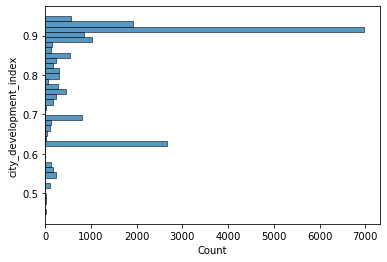

In [18]:
sns.histplot(data=data_deleted, y="city_development_index")

<AxesSubplot:xlabel='city_development_index', ylabel='target'>

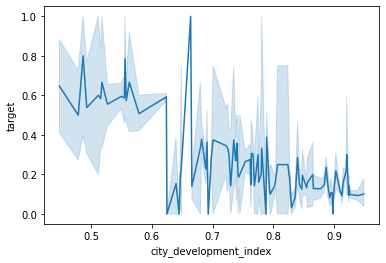

In [19]:
sns.lineplot(x='city_development_index', y='target', data=data_deleted)

It shows a clear trend that if a city has higher development, the possibility of the employee in that city willing to change a job is low. Thus **city_development_index** (index) is a useful feature.

Since I want to what the relationship between city and index, I decide to check whether they have one-to-one relationship.

In [20]:
data_deleted[['city','city_development_index']].groupby(['city']).city_development_index.std().nlargest(10)

city
city_1      0.0
city_10     0.0
city_100    0.0
city_101    0.0
city_102    0.0
city_103    0.0
city_104    0.0
city_105    0.0
city_106    0.0
city_107    0.0
Name: city_development_index, dtype: float64

They could be seen as one feature, and since **city_development_index** has more value, I keep it.

In [21]:
to_drop = ['city']

for feature in to_drop:
    categorical_features.remove(feature)
    nominal_features.remove(feature)
    
data_deleted = data_deleted.drop(to_drop, axis = 1)
data_deleted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18908 entries, 0 to 19157
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18908 non-null  float64
 1   gender                  14608 non-null  object 
 2   relevent_experience     18908 non-null  object 
 3   enrolled_university     18637 non-null  object 
 4   education_level         18624 non-null  object 
 5   major_discipline        16336 non-null  object 
 6   experience              18862 non-null  object 
 7   last_new_job            18573 non-null  object 
 8   training_hours          18908 non-null  int64  
 9   target                  18908 non-null  float64
dtypes: float64(2), int64(1), object(7)
memory usage: 1.6+ MB


### Feature: gender

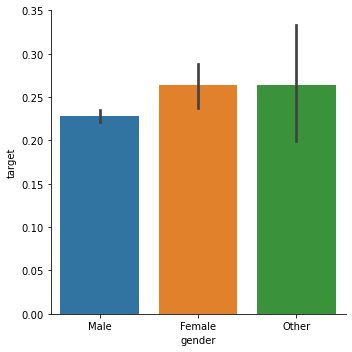

In [22]:
sns.catplot(data=data_deleted, kind="bar", x="gender", y="target")

Obversation shows that Female and Other has stronger willing to change job than Male, even though the confidential interval is longer.
Besides, the dataset is imbalanced, so we can't conclude all gender has low willing.

However, from many lines above, I know Other gender is uncommon, and there exists missing values. I wonder if I could do something here.

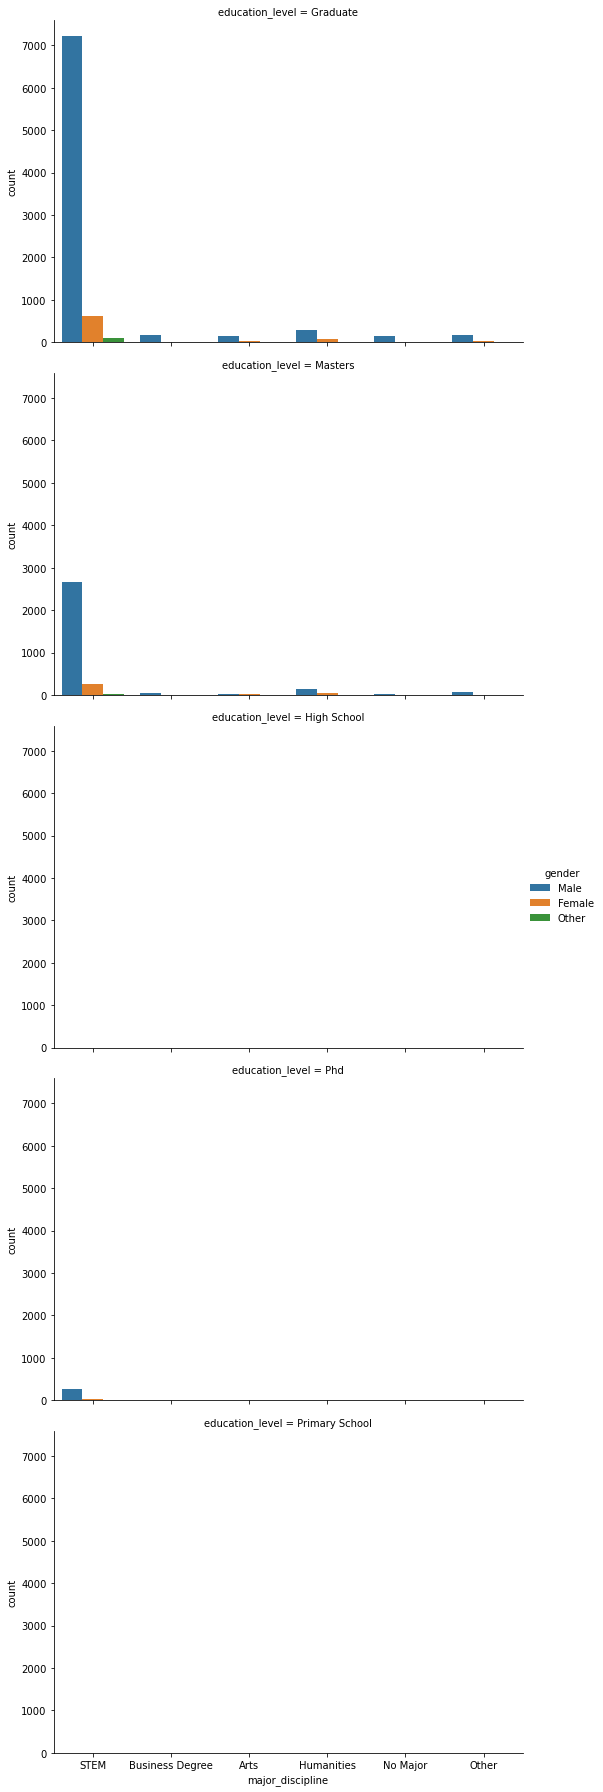

In [23]:
g = sns.catplot(
    data=data_deleted, hue="gender",
    x="major_discipline", row = "education_level",
    kind="count", height=5, aspect=1.5,
)

Some points:

- Female and Other gender have some similiarity to extent, so I turn Other into female.
- Other can not give me too much details.
- Since there we suddenly find if education level is lower than or equal to high school, then major_discipline will become missing value. We decide to cope with it later.

In [24]:
data_deleted.loc[data_deleted['gender'] == 'Other', 'gender'] = 'Female'
data_deleted.groupby(['gender']).target.count()

gender
Female     1423
Male      13185
Name: target, dtype: int64

### Features: major_discipline, enrolled_university, education_level (analyse and clean)

In [25]:
data_deleted[data_deleted['education_level'].isin(['Primary School','High School'])].major_discipline.count()

0

As inferred before, they are missing.

In [26]:
data_deleted.loc[data_deleted['education_level'].isin(['Primary School','High School']), 'major_discipline'] = 'No Major'

Besides, I'd like know whether this pattern occur in other features.

In [27]:
data_deleted[data_deleted['education_level'].isin(['Primary School','High School'])].groupby(['enrolled_university']).target.count()

enrolled_university
Full time course     877
Part time course     172
no_enrollment       1178
Name: target, dtype: int64

But it doesn't.

In [28]:
data_deleted.loc[data_deleted['education_level'].isin(['Primary School','High School']), 'enrolled_university'] = 'no_enrollment'

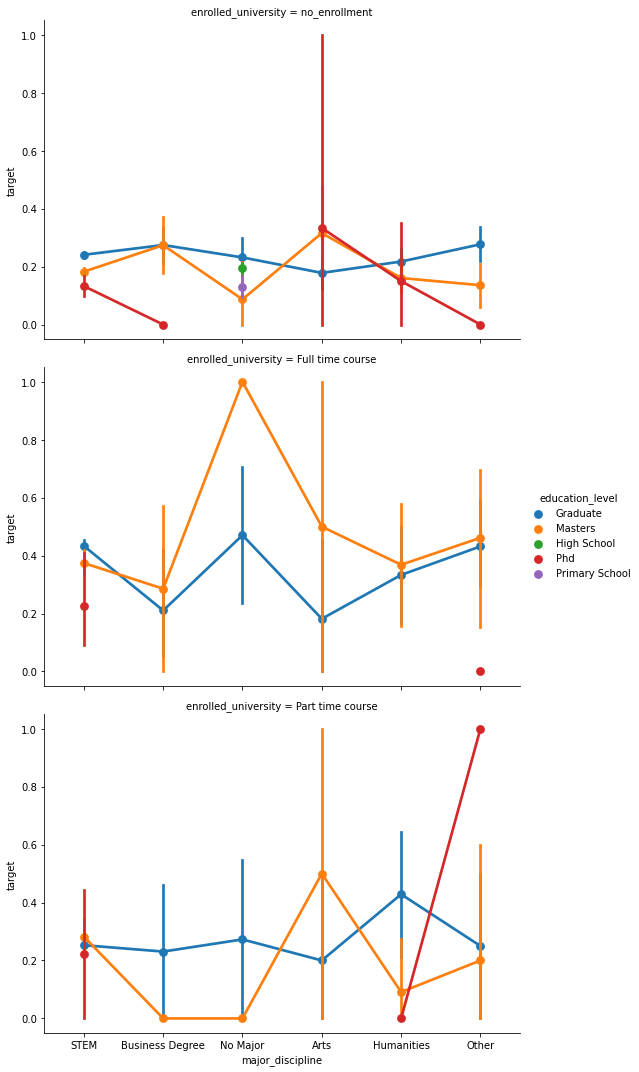

In [29]:
g = sns.catplot(
    data=data_deleted, hue="education_level", y="target",
    x="major_discipline", row = "enrolled_university",
    kind="point", height=5, aspect=1.5,
)

### Feature: relevant experience

In [30]:
# correlation
data_deleted[['relevent_experience', 'target']].groupby(['relevent_experience'], as_index=False).mean().sort_values(by='target', ascending=False)

,relevent_experience,target
1,No relevent experience,0.343641
0,Has relevent experience,0.214067


relevant_experience has good correlation with target.

### Feature: training hours

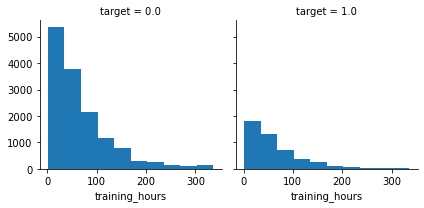

In [31]:
g = sns.FacetGrid(data_deleted, col='target')
g.map(plt.hist, 'training_hours', bins=10)

I found there are some values higher than 300, and believe it produces bad model for us. Also, the standard deviation of it reaches 65, which represents the large flutuation and proves what I have said. 

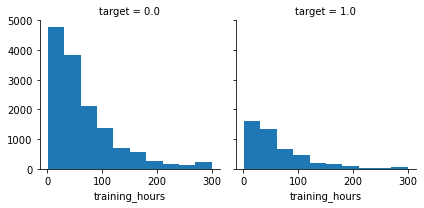

In [32]:
data_deleted['training_hours'] = data_deleted['training_hours'].apply(lambda x: x if x <= 300 else 300) 

g = sns.FacetGrid(data_deleted, col='target')
g.map(plt.hist, 'training_hours', bins=10)

## 5. Handling Missing values

Take a look what features have issues, and we are going to handle.

In [33]:
data_deleted.isnull().sum()

city_development_index       0
gender                    4300
relevent_experience          0
enrolled_university        235
education_level            284
major_discipline           309
experience                  46
last_new_job               335
training_hours               0
target                       0
dtype: int64

gender has many to cope, and last_new_job, experience, major_discipline, education_level and enrolled_university do not miss too much 
because of some operations done before. 

In [34]:
issue_features = ["last_new_job", "experience", "major_discipline", "education_level", "enrolled_university"]
data_handled = data_deleted.copy()
for f in issue_features:
    data_handled[f].fillna(value = data_handled[f].mode()[0], inplace=True)
    #print(data_handled[f].mode()[0])
    
data_handled.isnull().sum()

city_development_index       0
gender                    4300
relevent_experience          0
enrolled_university          0
education_level              0
major_discipline             0
experience                   0
last_new_job                 0
training_hours               0
target                       0
dtype: int64

In [35]:
# gender still use the mode
#data_handled['gender'].fillna(value = data_handled['gender'].mode()[0], inplace=True)
data_handled['gender'].fillna(value = 'Female', inplace=True)

In [36]:
data_handled.isnull().sum()

city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
last_new_job              0
training_hours            0
target                    0
dtype: int64

## Feature Selection

3 taught methods are going to see which one has stronger justification.

In [37]:
data_handled['city_development_index'].dtype

dtype('float64')

## 6. Data Preparing

According to different categorical features we have, we will transform them in different ways.

- ordinal features: According to their positions to encode.
- nomial features: Number encoding (because of no rank)

In [38]:
print('These are ordinal and binary feature list: {} {}'.format(ordinal_features, binary_features))
print('This is nomial feature list: {}'.format(nominal_features))

These are ordinal and binary feature list: ['relevent_experience', 'education_level', 'experience', 'last_new_job'] ['gender']
This is nomial feature list: ['enrolled_university', 'major_discipline']


In [39]:
num_encode = {
    'enrolled_university':{ 'no_enrollment': 0, 'Full time course': 1, 'Part time course': 2},
    'major_discipline':{ 'STEM': 0, 'Humanities': 1, 'Other': 2, 'Business Degree': 3, 'Arts': 4, 'No Major': 5},
    'gender': {'Male': 0, 'Female': 1}
}
# in terms of education_level, I want to use how long they have in the school, so I define that
# primary school should have 6 years, high school 12 (3+3) yrs, graduate 16 yrs, masters 18 yrs, phd 21 yrs. 
rank_encode = {
    'relevent_experience':{'Has relevent experience': 1, 'No relevent experience': 0}, 
    'education_level':{'Graduate': 16, 'Masters': 18, 'High School': 12, 'Phd': 21, 'Primary School': 6},
    'experience':{}, # directly apply it in formula 
    'last_new_job':{} # the same above
}

def experience_encode(x):
    if x == '>20':
        return 21
    elif x == '<1':
        return 0
    else:
        return int(x)
    
def last_new_job_encode(x):
    if x == '>4':
        return 5
    elif x == 'never':
        return 0
    else:
        return int(x)

Then a replace method to encode these labels into numeric ones.

In [40]:
data_encoded = data_handled.copy()

data_encoded.replace(num_encode, inplace=True)
data_encoded.replace(rank_encode, inplace=True)
data_encoded.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,0.920,0,1,0,16,0,>20,1,36,1.0
1,0.776,0,0,0,16,0,15,>4,47,0.0
2,0.624,1,0,1,16,0,5,never,83,0.0
3,0.789,1,0,0,16,3,<1,never,52,1.0
4,0.767,0,1,0,18,0,>20,4,8,0.0


In [41]:
data_encoded['experience'] = data_encoded['experience'].apply(experience_encode)
data_encoded['last_new_job'] = data_encoded['last_new_job'].apply(last_new_job_encode)
data_encoded.head()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
0,0.920,0,1,0,16,0,21,1,36,1.0
1,0.776,0,0,0,16,0,15,5,47,0.0
2,0.624,1,0,1,16,0,5,0,83,0.0
3,0.789,1,0,0,16,3,0,0,52,1.0
4,0.767,0,1,0,18,0,21,4,8,0.0


In [42]:
data_encoded.describe()

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,last_new_job,training_hours,target
count,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000,18908.000000
mean,0.829421,0.302676,0.726359,0.257880,15.996139,0.838481,10.184948,1.993283,65.182674,0.249524
std,0.123049,0.459428,0.445839,0.546779,2.171578,1.752085,6.778829,1.664550,59.248036,0.432749
min,0.448000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.740000,0.000000,0.000000,0.000000,16.000000,0.000000,4.000000,1.000000,23.000000,0.000000
50%,0.910000,0.000000,1.000000,0.000000,16.000000,0.000000,9.000000,1.000000,47.000000,0.000000
75%,0.920000,1.000000,1.000000,0.000000,18.000000,0.000000,16.000000,3.000000,88.000000,0.000000
max,0.949000,1.000000,1.000000,2.000000,21.000000,5.000000,21.000000,5.000000,300.000000,1.000000


In [43]:
best_features = SelectKBest(score_func=f_classif, k=7).fit(data_encoded.iloc[:, :-1], data_encoded['target'])

dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(data_encoded.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(9,'Score'))

                    Specs        Score
0  city_development_index  2478.193013
6              experience   614.734925
2     relevent_experience   343.026499
3     enrolled_university   231.764360
7            last_new_job   144.050931
1                  gender   106.983212
5        major_discipline    52.719566
8          training_hours     9.208246
4         education_level     3.871003


As we can observe, the first six features significantly larger than the other three.

* candidate to filter: training_hours, education_level and gender

<AxesSubplot:>

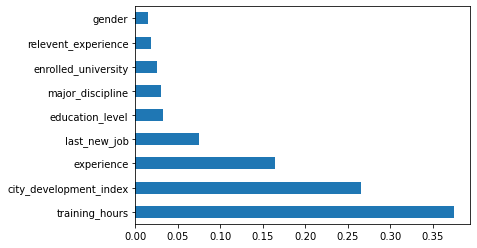

In [44]:
feature_tree = ExtraTreesClassifier().fit(data_encoded.iloc[:, :-1], data_encoded['target'])

#visualization
df_feature_importances = pd.Series(feature_tree.feature_importances_, index=data_encoded.columns[:-1])
df_feature_importances.nlargest(9).plot(kind='barh')

It's quite strange to figure out that training hours shows extremely high score, and I think it is because the classifier is overfitting, due to the tremedous amount of different hours.

Also, gender feature is still the lowest. *Maybe it's caused by my imputation on gender, however, after I tried to impute missing value with Female, the situation didn't change too much.(didn't show on the notebook, for the size)* 

- after it, `SelectKBest` improves a little, but `Tree` and `correlation` doesn't.
- I decide not to choose it.

<AxesSubplot:>

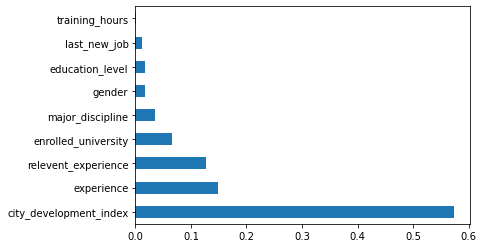

In [45]:
# avoid overfitting, by max depth
feature_tree = ExtraTreesClassifier(max_depth = 4, random_state = 88).fit(data_encoded.iloc[:, :-1], data_encoded['target'])

#visualization
df_feature_importances = pd.Series(feature_tree.feature_importances_, index=data_encoded.columns[:-1])
df_feature_importances.nlargest(9).plot(kind='barh')

As I hypotheses that model is overfitting, the plot proves my words.

Again, it shows `city_development_index`, `relevant_experience` and `experience` features matter. 

However, now job becomes lower.

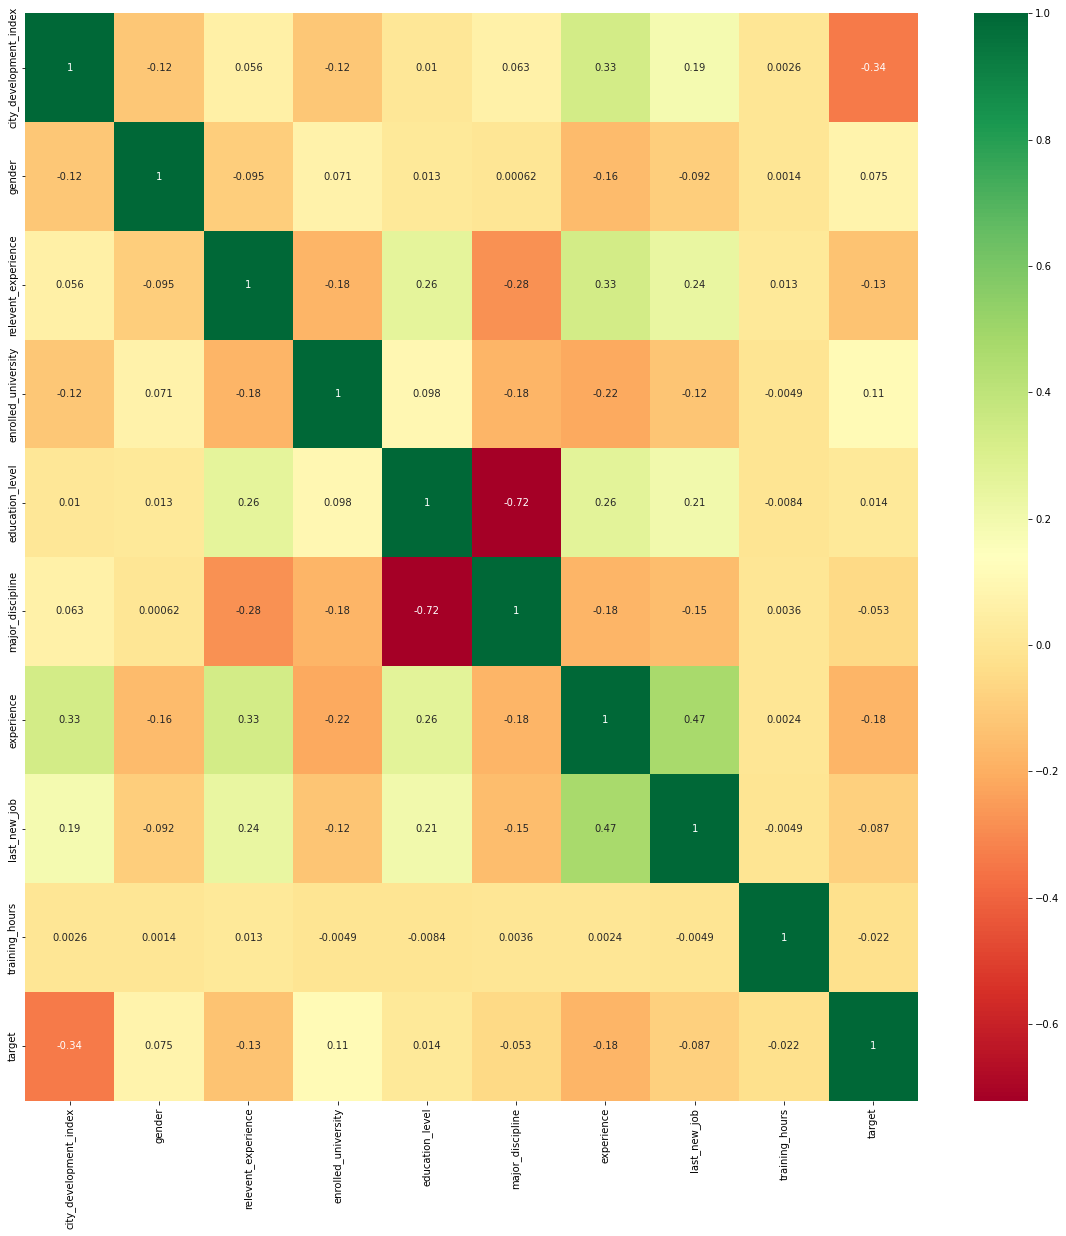

In [46]:
corr_mat = data_encoded.corr()

plt.figure(figsize=(20,20))
g=sns.heatmap(corr_mat,annot=True,cmap="RdYlGn")

We could find strong correlation relationship between **education level** and **major discipline**, so they are interacting features, and I will keep it. 

Now, **last_new_job** have correlation with **experience**, so I decided to create a new feature based on them.
Since we know that experience include the year between previous job and current job. Besides, **relevant_experience** shows some correlation. I need to do some visulization to know whether they are correlated.

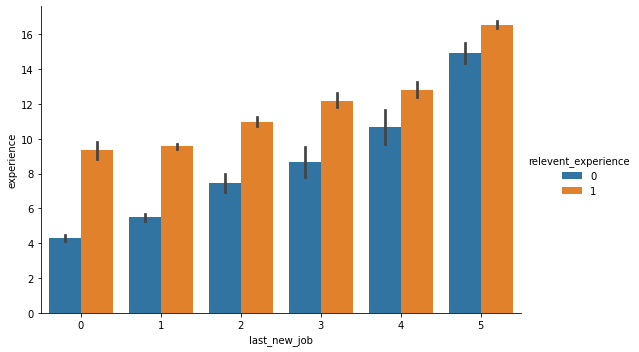

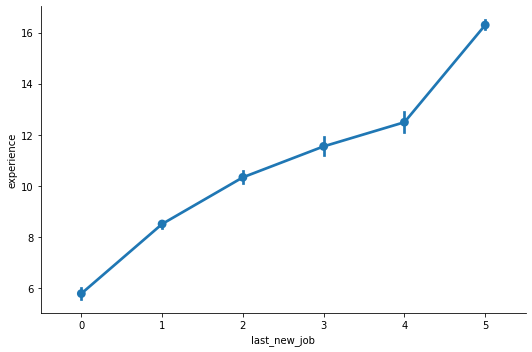

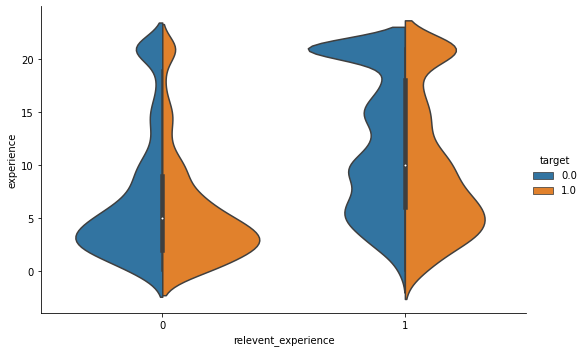

In [47]:
g = sns.catplot(
    data=data_encoded, hue="relevent_experience",
    x="last_new_job", y="experience",
    kind="bar", height=5, aspect=1.5,
)
g = sns.catplot(
    data=data_encoded, 
    x="last_new_job", y="experience",
    kind="point", height=5, aspect=1.5,
)
g = sns.catplot(
    data=data_encoded, hue="target",
    x="relevent_experience", y="experience",
    kind="violin", height=5, aspect=1.5, split=True
)

- If has relevant experience, the total experience year is larger
- Last new job increases, the total experience increase, too. And 5 years has strong climb, and I deduce that is because I transform >4 into 5.
- We could find in the third figure, more people who have many experience don't want to change the job.

In [48]:
# change the experience into the experience year subjects the last_new_job year
# it is defined as the years that employee experienced when leaving the last job
last_job_experience = data_encoded['experience'] - data_encoded['last_new_job']
last_job_experience.unique()

array([20, 10,  5,  0, 17,  4,  8,  6, 12,  2, 18, 11,  1,  7,  3,  9, -1,
       13, 16, 14, 15, 19, -2, 21, -5, -3, -4])

Something wried happen, but I remember that there is missing value imputation on that because of the mode value of that feature. So I change the negative years into zero, which is the same to impute experience value with the last_new_job value. 

Drop the old two feature and add the new feature.

In [49]:
last_job_experience = np.maximum(last_job_experience, 0)
print(last_job_experience.unique())

to_drop = ['experience','last_new_job']

for feature in to_drop:
    categorical_features.remove(feature)
    ordinal_features.remove(feature)

categorical_features.append('last_job_experience')
ordinal_features.append('last_job_experience')
data_encoded = data_encoded.drop(to_drop, axis = 1)

[20 10  5  0 17  4  8  6 12  2 18 11  1  7  3  9 13 16 14 15 19 21]


In [50]:
data_encoded.insert(1, "last_job_experience", last_job_experience)
data_encoded.head()

,city_development_index,last_job_experience,gender,relevent_experience,enrolled_university,education_level,major_discipline,training_hours,target
0,0.920,20,0,1,0,16,0,36,1.0
1,0.776,10,0,0,0,16,0,47,0.0
2,0.624,5,1,0,1,16,0,83,0.0
3,0.789,0,1,0,0,16,3,52,1.0
4,0.767,17,0,1,0,18,0,8,0.0


#### transform training hours

To prove whether could keep the training hour, I encoded it by rank encoding

In [51]:
def train_encode(x):
    return x//100 # only 0, 1, 2, 3

In [52]:
data_encoded['training_hours'] = data_encoded['training_hours'].apply(train_encode)
data_encoded['training_hours'].unique()

array([0, 1, 2, 3])

See the its score again.

                    Specs        Score
0  city_development_index  2478.193013
1     last_job_experience   565.182169
3     relevent_experience   343.026499
4     enrolled_university   231.764360
2                  gender   106.983212
6        major_discipline    52.719566
7          training_hours     8.906394
5         education_level     3.871003


<AxesSubplot:>

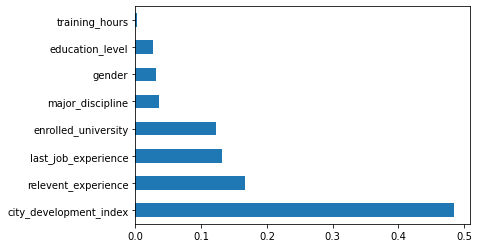

In [53]:
best_features = SelectKBest(score_func=f_classif, k=7).fit(data_encoded.iloc[:, :-1], data_encoded['target'])

dfscores = pd.DataFrame(best_features.scores_)
dfcolumns = pd.DataFrame(data_encoded.columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(9,'Score'))

feature_tree = ExtraTreesClassifier(max_depth = 4, random_state = 88).fit(data_encoded.iloc[:, :-1], data_encoded['target'])

#visualization
df_feature_importances = pd.Series(feature_tree.feature_importances_, index=data_encoded.columns[:-1])
df_feature_importances.nlargest(9).plot(kind='barh')

In conclusion, training hour is not a good feature. And we can see good score on the new feature **last_job_experience**.

### Back to feature selection
Now I decide to keep **city_development_index, relevant_experience, enrolled university, last_job_experience, major_discipline**.
In other words, I am going to remove **training_hours, education_level and gender**.

In [56]:
to_drop = ['training_hours', 'education_level', 'gender']

for feature in to_drop[1:]:
    categorical_features.remove(feature)
    
    
binary_features.remove('gender')
continuous_features.remove('training_hours')
ordinal_features.remove('education_level')

In [62]:
data_selected = data_encoded.copy()

data_selected.drop(to_drop, axis = 1, inplace = True)

In [63]:
data_selected.head()

,city_development_index,last_job_experience,relevent_experience,enrolled_university,major_discipline,target
0,0.920,20,1,0,0,1.0
1,0.776,10,0,0,0,0.0
2,0.624,5,0,1,0,0.0
3,0.789,0,0,0,3,1.0
4,0.767,17,1,0,0,0.0


Feature selection finished.

### Normalize

In [64]:
normalized_cols = ['last_job_experience']

# different normalization might be used
scaler = MinMaxScaler()
data_scaled = data_selected.copy()
data_scaled[normalized_cols] = scaler.fit_transform(data_scaled[normalized_cols])
data_scaled.head()

,city_development_index,last_job_experience,relevent_experience,enrolled_university,major_discipline,target
0,0.920,0.952381,1,0,0,1.0
1,0.776,0.476190,0,0,0,0.0
2,0.624,0.238095,0,1,0,0.0
3,0.789,0.000000,0,0,3,1.0
4,0.767,0.809524,1,0,0,0.0


### Split data
My strategy is that the training set will be handled with k-fold cross validation, and the test set is going to be evaluate.

In [65]:
categorical_features.remove('target')

In [66]:
X = data_scaled[categorical_features+continuous_features]
y = data_scaled['target']

Divide data into train, validation and test sets.

In [67]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size = 0.3, random_state = 88)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, train_size = 0.3, random_state = 88)

## 7. Model, predict and evaluate.

Training set is going to be used with 7-fold cross validation.

### DecisionTree

- Strong reason to choose this model, because it accepts categorical data, and most features of this dataset are categorical.
- However, I think we need to have feature engineering, because there are many feature now, which makes the model to predict worse.

Hyperparameters: `criterion:  {“gini”, “entropy”, “log_loss”}`, `max_depth`, `class_weight` (used for imbalanced dataset)

Try one, firstly.

In [68]:
first_tree = DecisionTreeClassifier(criterion='entropy', random_state = 88)

In [69]:
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=88)

In [70]:
pred = first_tree.predict(X_test)

In [71]:
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.79      0.85      0.82      9907
         1.0       0.41      0.31      0.35      3329

    accuracy                           0.72     13236
   macro avg       0.60      0.58      0.59     13236
weighted avg       0.69      0.72      0.70     13236



[Text(167.4, 181.2, 'city_development_index <= 0.694\nentropy = 0.792\nsamples = 1701\nvalue = [1296, 405]\nclass = Not Looking for job'),
 Text(83.7, 108.72, 'city_development_index <= 0.625\nentropy = 1.0\nsamples = 355\nvalue = [177, 178]\nclass = Looking for job'),
 Text(41.85, 36.23999999999998, '\n  (...)  \n'),
 Text(125.55000000000001, 36.23999999999998, '\n  (...)  \n'),
 Text(251.10000000000002, 108.72, 'relevent_experience <= 0.5\nentropy = 0.655\nsamples = 1346\nvalue = [1119, 227]\nclass = Not Looking for job'),
 Text(209.25, 36.23999999999998, '\n  (...)  \n'),
 Text(292.95, 36.23999999999998, '\n  (...)  \n')]

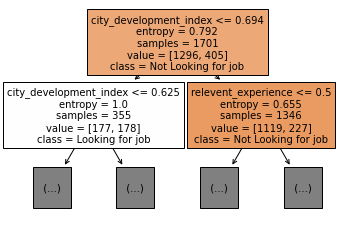

In [72]:
target_names = ['Not Looking for job', 'Looking for job']
tree.plot_tree(first_tree, max_depth = 1, feature_names = X.columns, fontsize = 10, filled = True, class_names = target_names)

#### Hyperparameter tuning and cross validation
Due to too many experiments done here, we use their combination to finish.

[Grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV) technique uses exhaustive search to know what the values of para(s)
used are the best through k-fold cross validation.

In [131]:
# to calculate Average class accuracy [since I can't find it in the documentation]
def ac_accuracy(test, pred):
    return np.sum(recall_score(test, pred, average = None))/2 #since I know the level is 2 already
    
    
aa = make_scorer(ac_accuracy, greater_is_better=True)

In [137]:
decision_tree = DecisionTreeClassifier(random_state = 88)
class_weight_paras = ["balanced"] # targets weight adjustment because of imbalanced dataset 
for i in range(2,10,2):
    class_weight_paras.append({0: 1, 1: i})
param_grid_tree = {'criterion':  ["gini", "entropy"], 'max_depth': range(2,15,1), 'class_weight': class_weight_paras}

grid_search_tree = GridSearchCV(decision_tree, param_grid_tree, cv=7, scoring=aa, verbose = 1, refit = True)

grid_search_tree.fit(X_train_val, y_train_val)
grid_search_tree.best_score_

Fitting 7 folds for each of 130 candidates, totalling 910 fits


0.6846281519388923

In [138]:
grid_search_tree.best_params_

{'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 4}

In [139]:
print(classification_report(y_pred=grid_search_tree.predict(X_test), y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      9907
         1.0       0.54      0.54      0.54      3329

    accuracy                           0.77     13236
   macro avg       0.69      0.69      0.69     13236
weighted avg       0.77      0.77      0.77     13236



Also, it is important to look through the score with different hyparameter, so that I can analyze it.

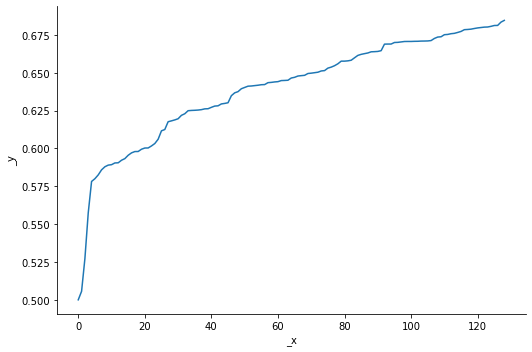

In [161]:
cv_results_tree = pd.DataFrame(grid_search_tree.cv_results_).set_index(['params'])
tree_score = cv_results_tree["mean_test_score"].ravel()
tree_rank = cv_results_tree["rank_test_score"].ravel()

g = sns.relplot(x=tree_rank.max() - tree_rank, y=tree_score, # let it go front
    kind="line", height=5, aspect=1.5
)

This graph shows the score that the training model used to reach.

In [162]:
grid_search_tree.best_params_

{'class_weight': {0: 1, 1: 2}, 'criterion': 'gini', 'max_depth': 4}

It's surely better the first one.

### LogisticRegression
Logistic regression is used to predict the category target.

Hyperparameters: `penalty`, `C`, `class_weight`


In [172]:
log_reg = LogisticRegression(random_state = 88, max_iter = 100)
param_grid_log = {'C':[0.001,0.01,0.1,1,10,100], 'penalty': ['l1'], 'solver': ['liblinear'], 'class_weight': class_weight_paras}

grid_search_log = GridSearchCV(log_reg, param_grid_log, cv=7, scoring=aa, verbose = 1, refit = True)

grid_search_log.fit(X_train_val, y_train_val)
grid_search_log.best_score_

Fitting 7 folds for each of 30 candidates, totalling 210 fits


0.683594019102129

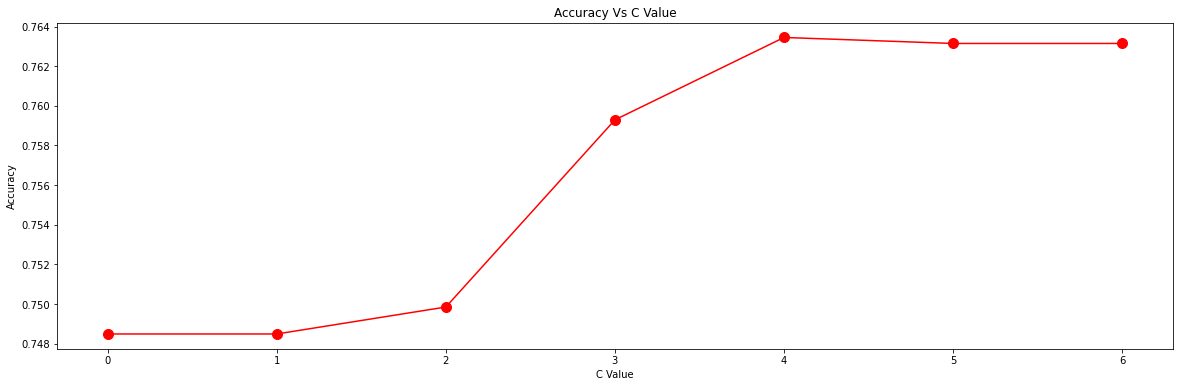

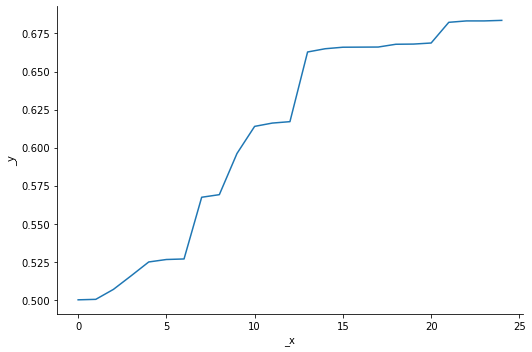

In [193]:
accuracy = []
for i in [0.001,0.01,0.1,1,10,100,1000]:
    log = LogisticRegression(random_state = 88, max_iter = 100, C = i)
    log.fit(X_train, y_train)
    pred_i = log.predict(X_test)
    accuracy.append(metrics.accuracy_score(y_test, pred_i))

plt.figure(figsize=(20, 6))
plt.plot(range(len([0.001,0.01,0.1,1,10,100,1000])), accuracy, color='red', marker='o',
         markersize=10)
plt.title('Accuracy Vs C Value')
plt.xlabel('C Value')
plt.ylabel('Accuracy')
### cite from lab04

cv_results_log = pd.DataFrame(grid_search_log.cv_results_).set_index(['params'])
log_score = cv_results_log["mean_test_score"].ravel()
log_rank = cv_results_log["rank_test_score"].ravel()

g = sns.relplot(x=log_rank.max() - log_rank, y=log_score, # let it go front
    kind="line", height=5, aspect=1.5
)

C value shows the learning rate. We can see from the plot that it initially increases but peak at point 5 (learning: 100).

#### One-hot encoding

gender, relevent_experience, enrolled_university, major_discipline need to be encoded into continuous by one-hot encoding,
since they don't have large or small comparison.

In [209]:
X_train_lg = pd.get_dummies(X_train, columns = ['relevent_experience', 'enrolled_university', 'major_discipline'])
X_train_val_lg = pd.get_dummies(X_train_val, columns = [ 'relevent_experience', 'enrolled_university', 'major_discipline'])
X_test_lg = pd.get_dummies(X_test, columns = ['relevent_experience', 'enrolled_university', 'major_discipline'])
X_val_lg = pd.get_dummies(X_val, columns = ['relevent_experience', 'enrolled_university', 'major_discipline'])

In [173]:
grid_search_log_encoded = GridSearchCV(log_reg, param_grid_log, cv=7, scoring=aa, verbose = 1, refit = True)

grid_search_log_encoded.fit(X_train_val_lg, y_train_val)
grid_search_log_encoded.best_score_

Fitting 7 folds for each of 30 candidates, totalling 210 fits


/Users/baoqinghang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baoqinghang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baoqinghang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baoqinghang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/baoqinghang/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.p

0.6847649512106024

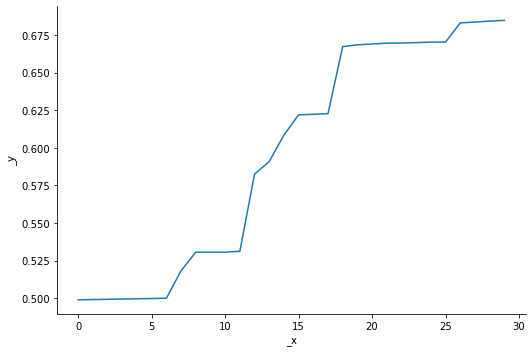

In [187]:
cv_results_log_encoded = pd.DataFrame(grid_search_log_encoded.cv_results_).set_index(['params'])
log_encoded_score = cv_results_log_encoded["mean_test_score"].ravel()
log_encoded_rank = cv_results_log_encoded["rank_test_score"].ravel()

g = sns.relplot(x=log_encoded_rank.max() - log_encoded_rank, y=log_encoded_score, # let it go front
    kind="line", height=5, aspect=1.5
)

After encoded by one-hot, it shows slightly better. However, it tells me that some warning and can't converge. so I have chose their max iteration to 100.

### K-Nearest Neighbours

Since K-NN is more preferred to use on continuous features, so I just one, and find it has low score.

Hyperparameters: `weight`, `p`, `n_neighbors`

In [94]:
knn = KNeighborsClassifier()
param_grid_knn = {"weights":["uniform", "distance"], "p" : range(1,3), "n_neighbors": range(3,60,5)}#

grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=7, scoring=aa, verbose = 1, refit = True)

grid_search_knn.fit(X_train_val, y_train_val)
grid_search_knn.best_score_

Fitting 7 folds for each of 144 candidates, totalling 1008 fits


0.6114219667121851

In [95]:
grid_search_knn.best_params_

{'n_neighbors': 38, 'p': 2, 'weights': 'distance'}

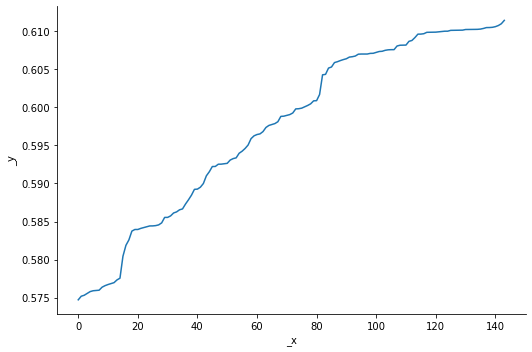

In [194]:
cv_results_knn = pd.DataFrame(grid_search_knn.cv_results_).set_index(['params'])
knn_score = cv_results_knn["mean_test_score"].ravel()
knn_rank = cv_results_knn["rank_test_score"].ravel()

g = sns.relplot(x=knn_rank.max() - knn_rank, y=knn_score, # let it go front
    kind="line", height=5, aspect=1.5
)

We can see the increase is not so dramatic.

### Categorical Naive Bayes algorithm
As I found Gaussian Naive Bayes algorithm is used to calculate the numeric features, I choose the [Categorical Naive Bayes algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.CategoricalNB.html#sklearn.naive_bayes.CategoricalNB) to train, which said suitable for classification with discrete features that are categorically distributed.

In [198]:
cnb = CategoricalNB()
param_grid_cnb = {"alpha":[i/10 for i in range(1,11)]}#, "fit_priorbool" : [True, False]

grid_search_nb = GridSearchCV(cnb, param_grid_cnb, cv=7, scoring=aa, verbose = 1, refit = True)

grid_search_nb.fit(X_train_val, y_train_val)
grid_search_nb.best_score_

Fitting 7 folds for each of 10 candidates, totalling 70 fits


0.5482976327562211

In [199]:
grid_search_nb.best_params_

{'alpha': 0.1}

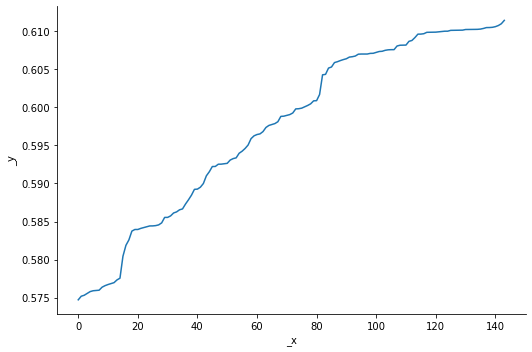

In [201]:
cv_results_knn = pd.DataFrame(grid_search_knn.cv_results_).set_index(['params'])
knn_score = cv_results_knn["mean_test_score"].ravel()
knn_rank = cv_results_knn["rank_test_score"].ravel()

g = sns.relplot(x=knn_rank.max() - knn_rank, y=knn_score, # let it go front
    kind="line", height=5, aspect=1.5
)

The model is as not good as knn model.

### Identification best model

We directly use test set to avoid remembering the dataset.

**********************************************************************
best decision tree model
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      9907
         1.0       0.54      0.54      0.54      3329

    accuracy                           0.77     13236
   macro avg       0.69      0.69      0.69     13236
weighted avg       0.77      0.77      0.77     13236

**********************************************************************
best logistic regression model
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.79      9907
         1.0       0.44      0.66      0.53      3329

    accuracy                           0.71     13236
   macro avg       0.65      0.69      0.66     13236
weighted avg       0.76      0.71      0.72     13236

**********************************************************************
best logistic regression model -- One hot
              precision    recall  

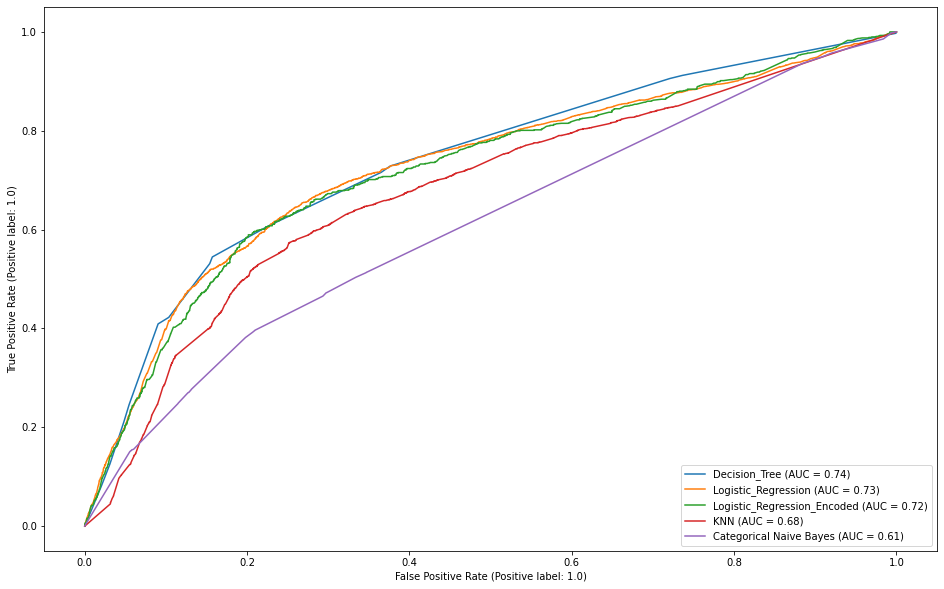

In [228]:
print("*"*70)
print("best decision tree model")
print(classification_report(y_pred=grid_search_tree.predict(X_test), y_true=y_test))
print("*"*70)
print("best logistic regression model")
print(classification_report(y_pred=grid_search_log.predict(X_test), y_true=y_test))
print("*"*70)
print("best logistic regression model -- One hot")
print(classification_report(y_pred=grid_search_log_encoded.predict(X_test_lg), y_true=y_test))
print("*"*70)
print("best knn model")
print(classification_report(y_pred=grid_search_knn.predict(X_test), y_true=y_test))
print("*"*70)
print("best categorical naive bayes model")
print(classification_report(y_pred=grid_search_nb.predict(X_test), y_true=y_test))

plt.figure(figsize=(16, 10))
ax = plt.gca()
plot_tree = plot_roc_curve(estimator=grid_search_tree, X=X_test, y=y_test, ax=ax, name='Decision_Tree')
plot_log = plot_roc_curve(estimator=grid_search_log, X=X_test, y=y_test, ax=ax, name='Logistic_Regression')
plot_log_encoded = plot_roc_curve(estimator=grid_search_log_encoded, X=X_val_lg, y=y_val, ax=ax, name='Logistic_Regression_Encoded')
plot_knn = plot_roc_curve(estimator=grid_search_knn, X=X_test, y=y_test, ax=ax, name='KNN')
plot_nb = plot_roc_curve(estimator=grid_search_nb, X=X_test, y=y_test, ax=ax, name='Categorical Naive Bayes')

- One hot Log_reg is better than not encoded.
- decision tree has better precision than other models.

### Ensembles
Ensemble technique increases the diversity and specialization on classification.
Let's see whether it does.
First, we try the above models identified having the best score.
#### Bagging
It could sample training data with bootstrap.

In [214]:
bag_nb = BaggingClassifier(base_estimator=grid_search_knn.best_estimator_, n_estimators=20)

bag_nb.fit(X_train, y_train.values.ravel())

BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=38,
                                                      weights='distance'),
                  n_estimators=20)

In [215]:
pred = bag_nb.predict(X_test)
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.84      9907
         1.0       0.48      0.32      0.38      3329

    accuracy                           0.74     13236
   macro avg       0.64      0.60      0.61     13236
weighted avg       0.72      0.74      0.72     13236



#### Random Forest

In [216]:
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=9)
rf_clf.fit(X_train, y_train.values.ravel())
pred = rf_clf.predict(X_test)
print(classification_report(y_pred=pred, y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85      9907
         1.0       0.56      0.34      0.42      3329

    accuracy                           0.77     13236
   macro avg       0.68      0.62      0.64     13236
weighted avg       0.74      0.77      0.75     13236



#### Voting classifier

In [224]:
voting_clf = VotingClassifier([('decTree', grid_search_tree), ('LogReg', grid_search_log), ('RandForest', rf_clf)], weights=None, voting='soft')
voting_clf.fit(X_train, y_train.values.ravel())
pred = voting_clf.predict(X_test)
print(classification_report(y_pred=pred, y_true=y_test))

Fitting 7 folds for each of 130 candidates, totalling 910 fits
Fitting 7 folds for each of 30 candidates, totalling 210 fits
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      9907
         1.0       0.53      0.55      0.54      3329

    accuracy                           0.77     13236
   macro avg       0.69      0.69      0.69     13236
weighted avg       0.77      0.77      0.77     13236



**********************************************************************
best decision tree model
              precision    recall  f1-score   support

         0.0       0.85      0.84      0.84      9907
         1.0       0.54      0.54      0.54      3329

    accuracy                           0.77     13236
   macro avg       0.69      0.69      0.69     13236
weighted avg       0.77      0.77      0.77     13236

**********************************************************************
best logistic regression model
              precision    recall  f1-score   support

         0.0       0.86      0.72      0.79      9907
         1.0       0.44      0.66      0.53      3329

    accuracy                           0.71     13236
   macro avg       0.65      0.69      0.66     13236
weighted avg       0.76      0.71      0.72     13236

**********************************************************************
best logistic regression model -- One hot
              precision    recall  

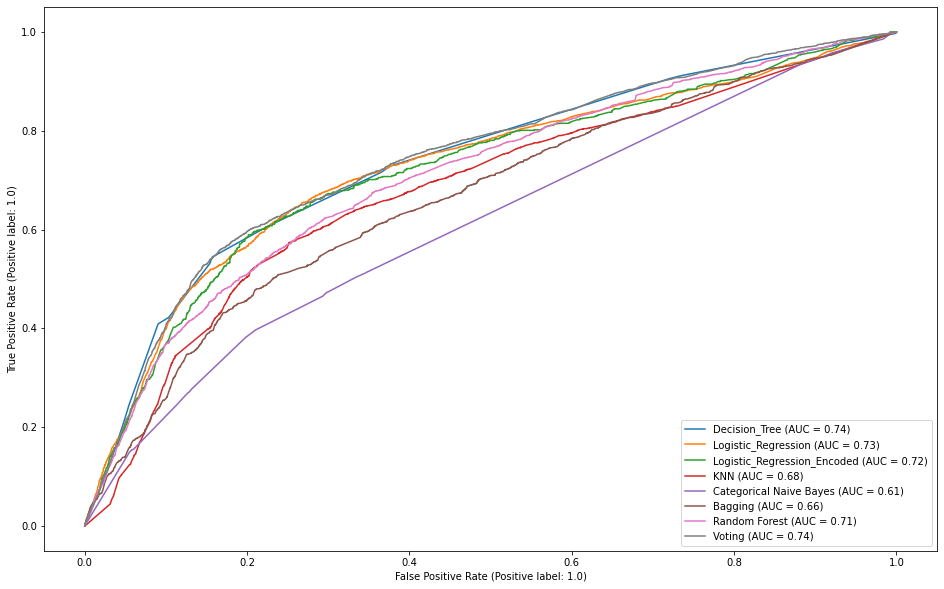

In [227]:
print("*"*70)
print("best decision tree model")
print(classification_report(y_pred=grid_search_tree.predict(X_test), y_true=y_test))
print("*"*70)
print("best logistic regression model")
print(classification_report(y_pred=grid_search_log.predict(X_test), y_true=y_test))
print("*"*70)
print("best logistic regression model -- One hot")
print(classification_report(y_pred=grid_search_log_encoded.predict(X_test_lg), y_true=y_test))
print("*"*70)
print("best knn model")
print(classification_report(y_pred=grid_search_knn.predict(X_test), y_true=y_test))
print("*"*70)
print("best categorical naive bayes model")
print(classification_report(y_pred=grid_search_nb.predict(X_test), y_true=y_test))

plt.figure(figsize=(16, 10))
ax = plt.gca()
plot_tree = plot_roc_curve(estimator=grid_search_tree, X=X_test, y=y_test, ax=ax, name='Decision_Tree')
plot_log = plot_roc_curve(estimator=grid_search_log, X=X_test, y=y_test, ax=ax, name='Logistic_Regression')
plot_log_encoded = plot_roc_curve(estimator=grid_search_log_encoded, X=X_val_lg, y=y_val, ax=ax, name='Logistic_Regression_Encoded')
plot_knn = plot_roc_curve(estimator=grid_search_knn, X=X_test, y=y_test, ax=ax, name='KNN')
plot_nb = plot_roc_curve(estimator=grid_search_nb, X=X_test, y=y_test, ax=ax, name='Categorical Naive Bayes')
plot_bag = plot_roc_curve(estimator=bag_nb, X=X_test, y=y_test, ax=ax, name='Bagging')
plot_rf = plot_roc_curve(estimator=rf_clf, X=X_test, y=y_test, ax=ax, name='Random Forest')
plot_voting = plot_roc_curve(estimator=voting_clf, X=X_test, y=y_test, ax=ax, name='Voting')